In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Veri yükleme
df = pd.read_csv("gym_members_exercise_tracking.csv")
df = df.dropna()
df.reset_index(drop=True, inplace=True)

print("Veri seti boyutu:", df.shape)
print("\nWorkout türleri dağılımı:")
print(df["Workout_Type"].value_counts())

Veri seti boyutu: (973, 15)

Workout türleri dağılımı:
Workout_Type
Strength    258
Cardio      255
Yoga        239
HIIT        221
Name: count, dtype: int64


In [22]:
# FEATURE ENGINEERING
df["HR_per_minute"] = df["Avg_BPM"] / (df["Session_Duration (hours)"] * 60)
df["Intensity_per_Weight"] = df["Calories_Burned"] / df["Weight (kg)"]
df["HRR"] = df["Max_BPM"] - df["Resting_BPM"]
df["Efficiency"] = df["Calories_Burned"] / df["Avg_BPM"]
df["Experience_Adjusted_Calories"] = df["Calories_Burned"] / (df["Experience_Level"] + 1)  # +1 to avoid division by zero
df["Anaerobic_Index"] = (df["Max_BPM"] - df["Avg_BPM"]) / df["Resting_BPM"]
df["BPM_Variance_Rest"] = (df["Avg_BPM"] - df["Resting_BPM"]) ** 2
df["Heart_Instability"] = abs(df["Max_BPM"] - df["Avg_BPM"]) / df["Max_BPM"]

# Ek feature'lar
df["Calories_per_Hour"] = df["Calories_Burned"] / df["Session_Duration (hours)"]
df["Heart_Efficiency"] = df["Calories_Burned"] / df["HRR"]
df["BMI_Category"] = pd.cut(df["BMI"], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3]).astype(int)
df["Age_Group"] = pd.cut(df["Age"], bins=[0, 25, 35, 45, 100], labels=[0, 1, 2, 3]).astype(int)

In [23]:
# Label Encoding
le_gender = LabelEncoder()
le_workout = LabelEncoder()

df["Gender_Code"] = le_gender.fit_transform(df["Gender"])
df["Workout_Code"] = le_workout.fit_transform(df["Workout_Type"])

In [24]:
# Feature seçimi
numerical_cols = [
    'Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage',
    'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Experience_Level',
    'BMI', 'HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency',
    'Experience_Adjusted_Calories', 'Anaerobic_Index',
    'BPM_Variance_Rest', 'Heart_Instability', 'BMI_Category', 'Age_Group',
    'Calories_per_Hour', 'Heart_Efficiency'
]

X = df[['Gender_Code', 'Workout_Code'] + numerical_cols]
y = df["Workout_Code"]

# ÖNEMLİ: Workout_Code'u feature olarak kullanmamak gerekiyor!
X = X.drop('Workout_Code', axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.41, random_state=42, stratify=y
)
#test-train split

In [26]:
# Önce Scaling, sonra SMOTE (daha iyi sonuç verir)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# SMOTE
sm = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print(f"\nEğitim seti boyutu (SMOTE sonrası): {X_train_res.shape}")
print(f"Test seti boyutu: {X_test_scaled.shape}")


Eğitim seti boyutu (SMOTE sonrası): (608, 26)
Test seti boyutu: (399, 26)


In [28]:

# Random Forest Model - Optimize edilmiş parametreler
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_res, y_train_res)


,n_estimators,300
,criterion,'gini'
,max_depth,15
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
# Tahmin ve değerlendirme
y_pred = rf.predict(X_test_scaled)

print("\n" + "="*50)
print("MODEL PERFORMANSI")
print("="*50)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_workout.classes_))


MODEL PERFORMANSI

Accuracy: 0.2506

Classification Report:
              precision    recall  f1-score   support

      Cardio       0.27      0.29      0.28       104
        HIIT       0.25      0.24      0.24        91
    Strength       0.23      0.25      0.24       106
        Yoga       0.25      0.21      0.23        98

    accuracy                           0.25       399
   macro avg       0.25      0.25      0.25       399
weighted avg       0.25      0.25      0.25       399



In [30]:
# Cross-validation skoru
cv_scores = cross_val_score(rf, X_train_res, y_train_res, cv=5)
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")



Cross-Validation Accuracy: 0.3225 (+/- 0.0840)


In [31]:
# Feature importance
importances = rf.feature_importances_
feat_list = X.columns
indices = np.argsort(importances)[::-1]

print("\n" + "="*50)
print("EN ÖNEMLİ FEATURE'LAR")
print("="*50)
for i in range(min(10, len(indices))):
    print(f"{i+1}. {feat_list[indices[i]]}: {importances[indices[i]]:.5f}")


EN ÖNEMLİ FEATURE'LAR
1. Experience_Adjusted_Calories: 0.05240
2. Heart_Efficiency: 0.05236
3. Fat_Percentage: 0.05116
4. Calories_per_Hour: 0.04950
5. BMI: 0.04942
6. HR_per_minute: 0.04725
7. Heart_Instability: 0.04691
8. HRR: 0.04654
9. Anaerobic_Index: 0.04641
10. Weight (kg): 0.04563


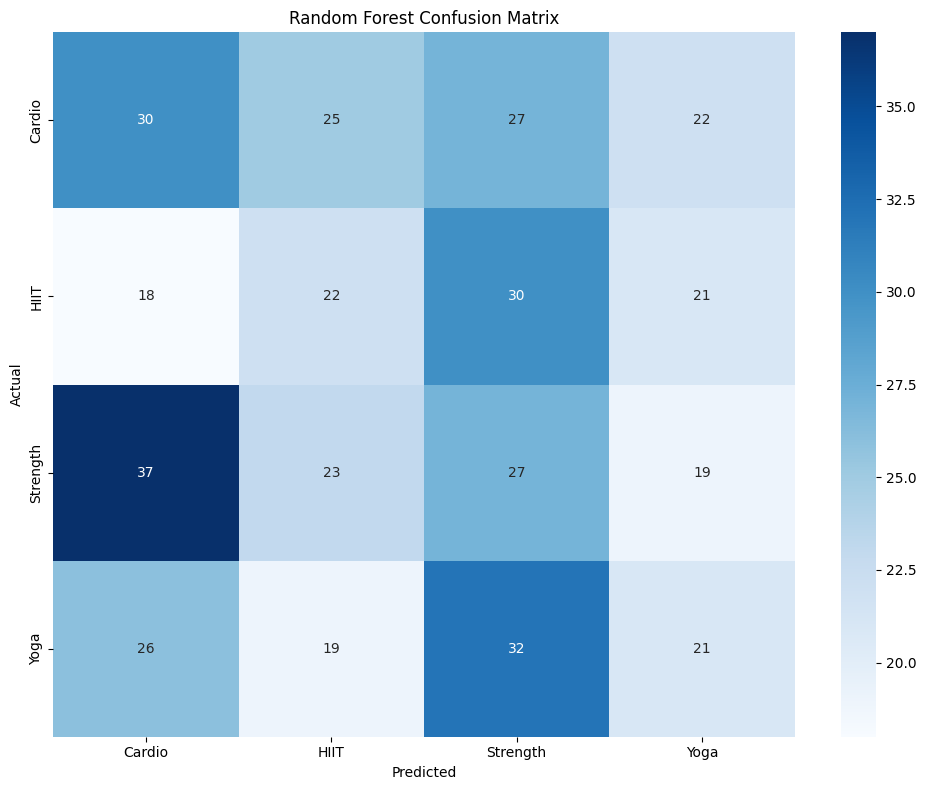

In [32]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_workout.classes_,
            yticklabels=le_workout.classes_)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

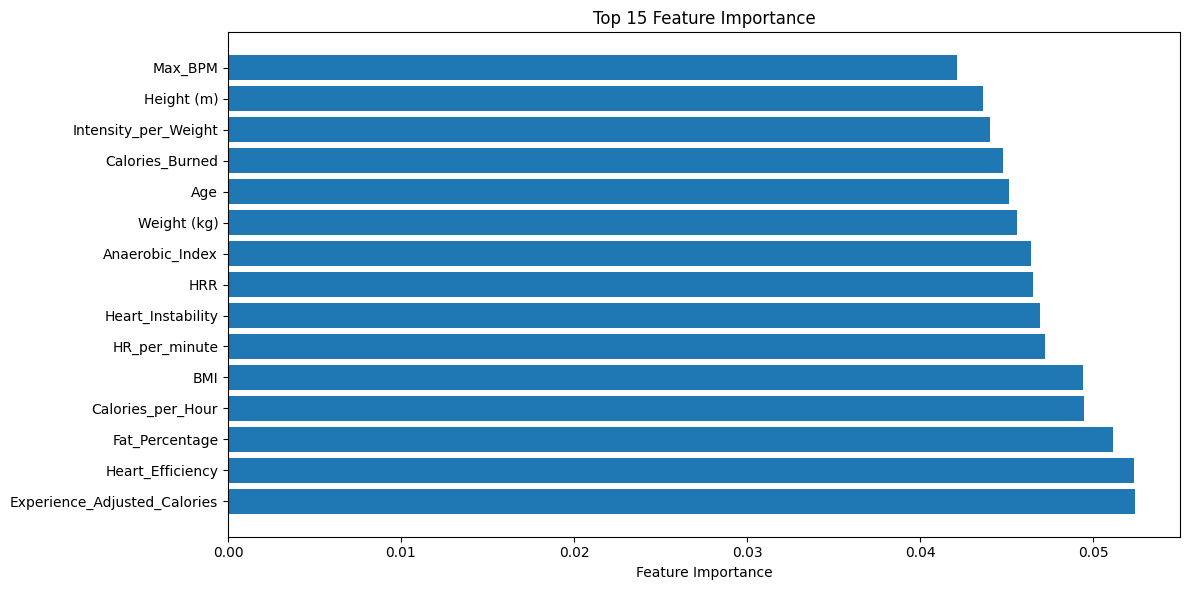

In [33]:
# Feature Importance Grafiği
plt.figure(figsize=(12, 6))
plt.barh(range(min(15, len(indices))), importances[indices[:15]])
plt.yticks(range(min(15, len(indices))), [feat_list[i] for i in indices[:15]])
plt.xlabel("Feature Importance")
plt.title("Top 15 Feature Importance")
plt.tight_layout()
plt.show()

In [34]:
# Hyperparameter tuning için GridSearch (opsiyonel - uzun sürebilir)
print("\n" + "="*50)
print("HYPERPARAMETER TUNING (GridSearch)")
print("="*50)

param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [12, 15, 18],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [3, 4, 5],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("GridSearch başlatılıyor...")
grid_search.fit(X_train_res, y_train_res)

print(f"\nEn iyi parametreler: {grid_search.best_params_}")
print(f"En iyi CV skoru: {grid_search.best_score_:.4f}")


HYPERPARAMETER TUNING (GridSearch)
GridSearch başlatılıyor...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

En iyi parametreler: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
En iyi CV skoru: 0.3109


In [35]:
# En iyi modelle tahmin
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)
print(f"Test seti accuracy (en iyi model): {accuracy_score(y_test, y_pred_best):.4f}")

Test seti accuracy (en iyi model): 0.2506
